In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import pyBigWig
import os
import umap
from sklearn.preprocessing import StandardScaler

from statannotations.Annotator import Annotator

2024-01-04 09:20:29.420163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
targets = pd.read_csv('../data/enformer_targets_human.txt', sep='\t')
cre_size = 5000
model = custom_model.Enformer()

2024-01-04 09:20:34.666962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 09:20:35.006623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 61221 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

    # pairs = ['Enhancer', 'Silencer']
    # order = ['Silencer', 'Enhancer']
    
    # ax = sns.boxplot(data=chromatin_marks, x=x, y=y, order=order, showfliers=False, palette={'Enhancer':'g', 'Silencer':'r'})
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # pairs=[("Enhancer", "Silencer")]
    
    # annotator = Annotator(ax, pairs, data=chromatin_marks, x=x, y=y, order=order)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    # annotator.apply_and_annotate()
    # plt.xlabel(descr)
    # plt.show()
    
    

In [4]:
def plot_umap(all_features, labels):
    reducer = umap.UMAP(random_state=42)
    scaled_penguin_data = StandardScaler().fit_transform(all_features)
    embedding = reducer.fit_transform(scaled_penguin_data)
    ax=sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1], hue=labels, alpha=0.3, palette=['g', 'r'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [5]:
cre_classifier = 'sufficiency'

cres = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')

K562


/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


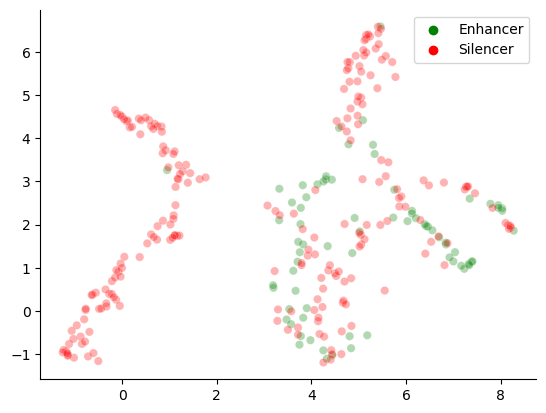

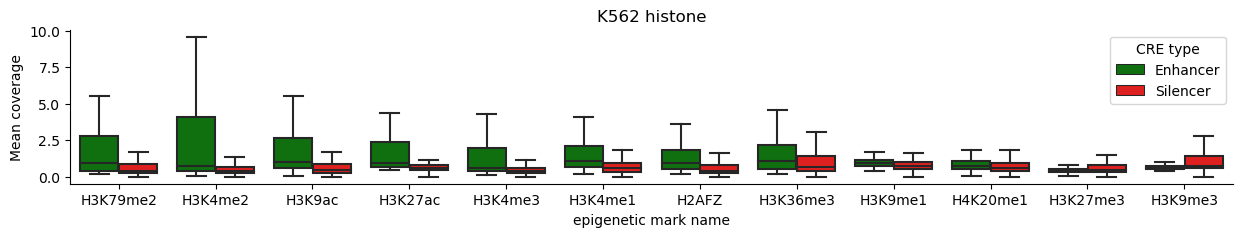

GM12878


/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


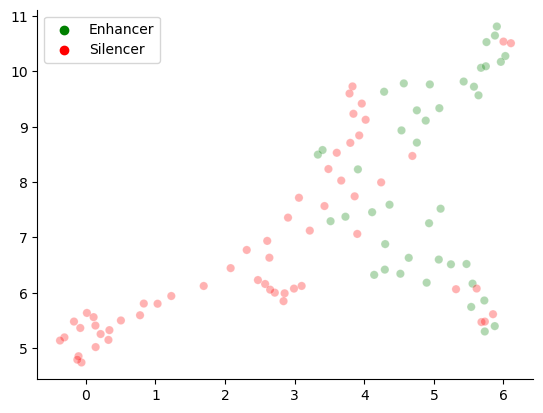

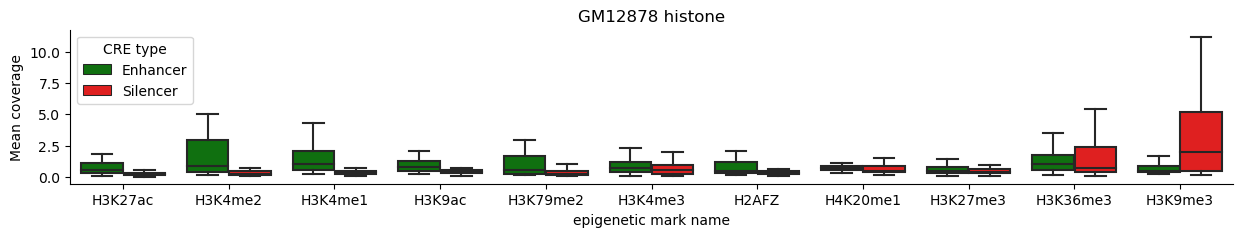

PC-3


/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


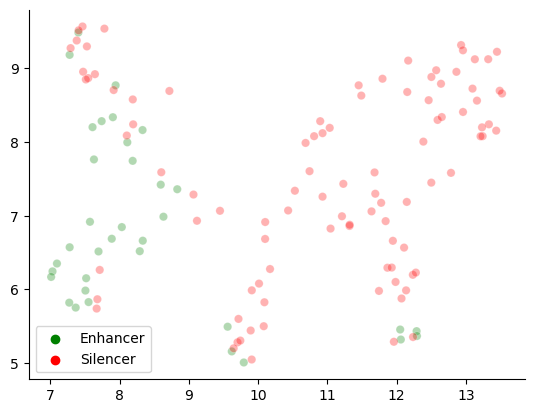

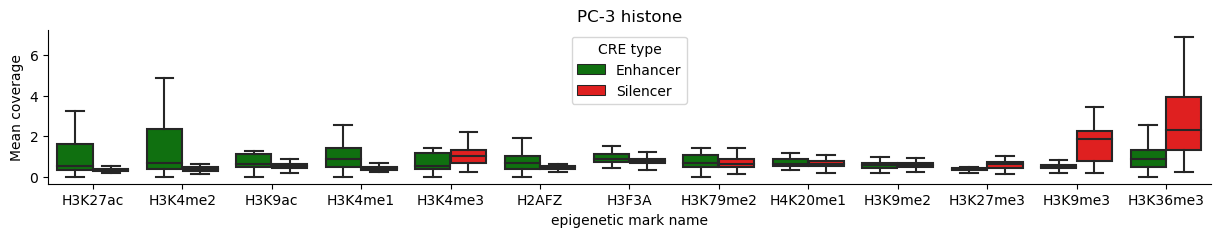

K562


/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


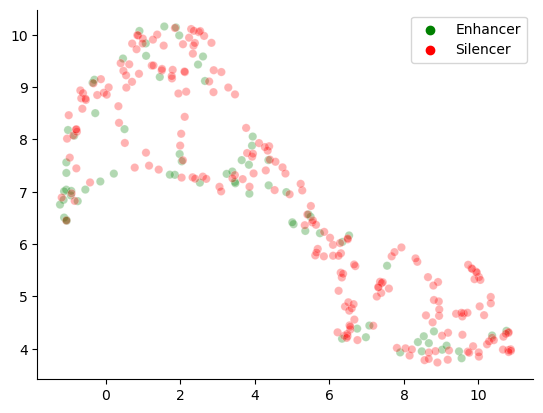

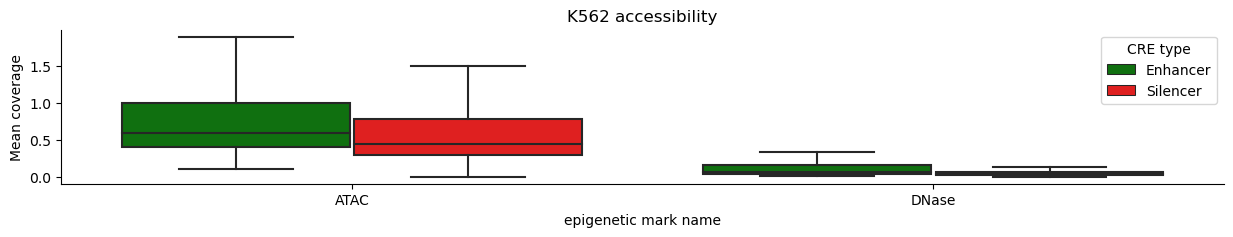

GM12878


/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


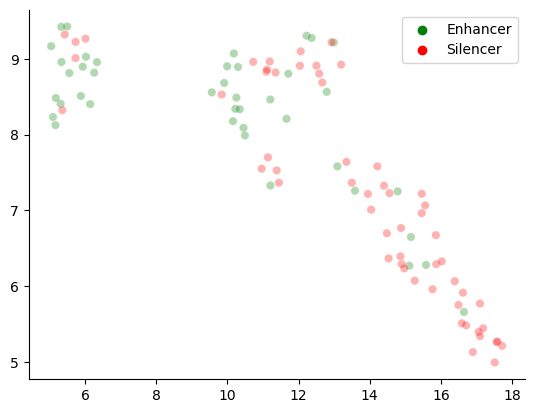

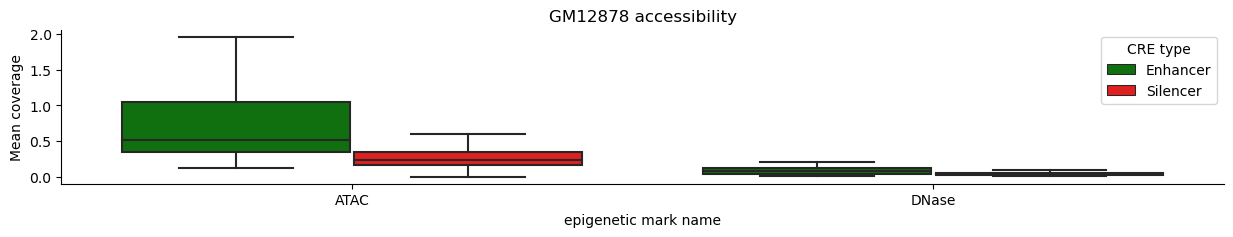

PC-3


/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


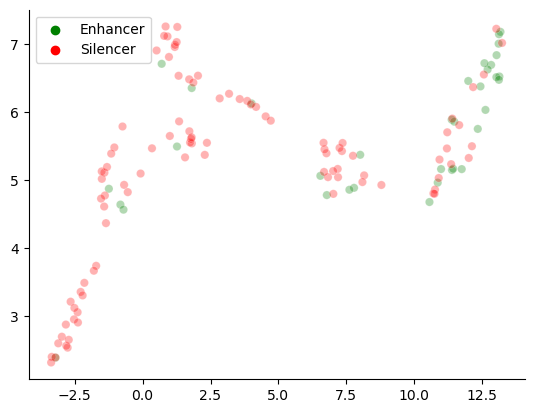

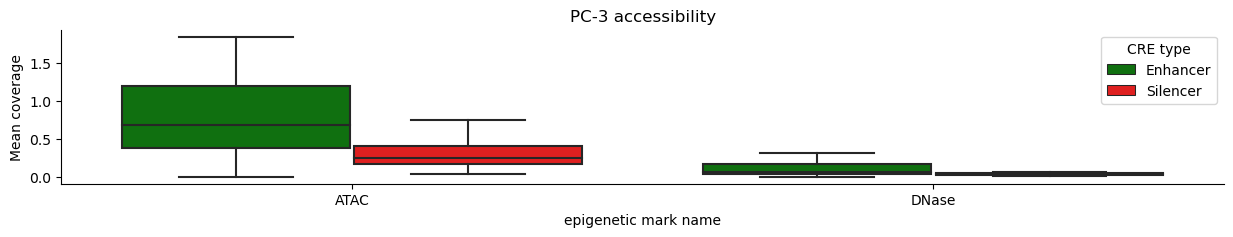

In [6]:
for assay in ['histone', 'accessibility']:
    for cell_line in ['K562', 'GM12878', 'PC-3']:
        print(cell_line)
        metadata = pd.read_csv(f'../data/{cell_line}/{assay}/metadata.csv')
        # x='cre'
        
        cell_df = cres[cres['cell_line']==cell_line]
        
        all_features = []
        descr_list = []
        for i, metadata_row in metadata.iterrows():
            bw_id = metadata_row['File accession']
            descr = metadata_row['Experiment target']
            if assay == 'accessibility':
                descr = metadata_row['Assay']
            descr = f'{descr}-{i}'
            y = descr
            
            bw = pyBigWig.open(f'../data/{cell_line}/{assay}/{bw_id}.bigWig')
            chromatin_marks = []
            cre_types = []
            for cre_type, df in cell_df.groupby('tile class'): 
                vals = []
                for i, row in df.iterrows():
                    chrom, tss = row['seq_id'].split('_')[1:3]
                    seq_start = int(tss) - model.seq_length//2
                    cre_start = seq_start + row['tile_start']
                    cre_end = cre_start + cre_size
                    v = bw.values(chrom, cre_start, cre_end)
                    vals.append(v)
                    cre_types.append(cre_type)
                    
                chromatin_marks_per_cre = pd.DataFrame.from_dict({y: np.array(vals).mean(axis=-1)})
                
                chromatin_marks.append(chromatin_marks_per_cre)
                
            chromatin_marks = pd.concat(chromatin_marks)
            all_features.append(chromatin_marks.reset_index(drop=True))
        all_features = pd.concat(all_features, axis=1)
        all_features['CRE type'] = cre_types
    
        plot_umap(all_features.iloc[:, :-1], cre_types)
        
        all_features_melted = all_features.melt(var_name='epigenetic mark', value_name='Mean coverage', value_vars=all_features.columns[:-1], id_vars='CRE type')
        
        all_features_melted['epigenetic mark name'] = [v.split('-')[0] for v in all_features_melted['epigenetic mark']]
        
        
        epi_diff_vals = []
        
        for epi_mark, df in all_features_melted.groupby('epigenetic mark name'):
            summary = df.groupby('CRE type').mean('Mean coverage')
            diff = summary.loc['Enhancer'].values - summary.loc['Silencer'].values
            epi_diff_vals.append([epi_mark, diff[0]])
        epi_diff_vals = pd.DataFrame(epi_diff_vals)
        order = epi_diff_vals.sort_values(1)[0].values[::-1]
        if assay != 'tf':
            fig, axes = plt.subplots(1, figsize=[15,2])
            ax=sns.boxplot(data=all_features_melted, x='epigenetic mark name', y='Mean coverage', hue='CRE type', showfliers=False, order=order,
                          palette={'Enhancer':'g', 'Silencer':'r'})
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
        plt.title(f'{cell_line} {assay}')
        
        plt.show()

In [21]:
# rm ../data/GM12878/tf/ENCFF531XDV.bigWig